# **Custom Multi-Layer Perceptron**

In [88]:
# Import Statements
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.special import expit
import sys
import pandas as pd

from typing import Tuple
import warnings
warnings.filterwarnings("ignore")

In [89]:
# Print Version
print("Pandas:", pd.__version__)
print("Numpy:", np.__version__)

Pandas: 2.0.3
Numpy: 1.25.2


## **1: Load, Split, Balance**

### **1.1: Loading Data In and Seeing Basic Characteristcs**

Here, we loaded the 2017 US Census Demographic dataset (from the DP03 and DP05 tables of the 2017 American Community Survey) into a Pandas DataFrame and display some of its key features. We will wait to one-hot-encode and normalize the data to test how our Two-Layer-Perceptron works without employing these techniques. Later, we will add them in one-by-one to see how these methods affect the performance of our perceptron. 

In [76]:
df_original_csv: pd.DataFrame = pd.read_csv("Dataset/acs2017_census_tract_data.csv")
df_original_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74001 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           74001 non-null  int64  
 1   State             74001 non-null  object 
 2   County            74001 non-null  object 
 3   TotalPop          74001 non-null  int64  
 4   Men               74001 non-null  int64  
 5   Women             74001 non-null  int64  
 6   Hispanic          73305 non-null  float64
 7   White             73305 non-null  float64
 8   Black             73305 non-null  float64
 9   Native            73305 non-null  float64
 10  Asian             73305 non-null  float64
 11  Pacific           73305 non-null  float64
 12  VotingAgeCitizen  74001 non-null  int64  
 13  Income            72885 non-null  float64
 14  IncomeErr         72885 non-null  float64
 15  IncomePerCap      73256 non-null  float64
 16  IncomePerCapErr   73256 non-null  float6

In [77]:
df_original_csv.head()

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga County,1845,899,946,2.4,86.3,5.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,Alabama,Autauga County,2172,1167,1005,1.1,41.6,54.5,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,Alabama,Autauga County,3385,1533,1852,8.0,61.4,26.5,0.6,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,Alabama,Autauga County,4267,2001,2266,9.6,80.3,7.1,0.5,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,Alabama,Autauga County,9965,5054,4911,0.9,77.5,16.4,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


In [78]:
# Dataset Size
row_count, col_count = df_original_csv.shape
print(f"The dataset contains {row_count} rows and {col_count} columns.")

The dataset contains 74001 rows and 37 columns.


After loading in the dataset, we calculate that there are 37 potential features and 74001 instances within the loaded dataset. 

### **1.2: Remove Observations That Have Missing Data**

Next, we will focus on handling the missing data. First, we want to detect the missing values by finding `null` values. Then, we can visualize the missing values using a heatmap where each yellow strip in the heatmap represents missing data in that column. The heatmap below gives us a quick summary of where data is missing. It looks like any columns with missing data are limited to only a certain number of instances, as the yellow strips are in the same rows. 

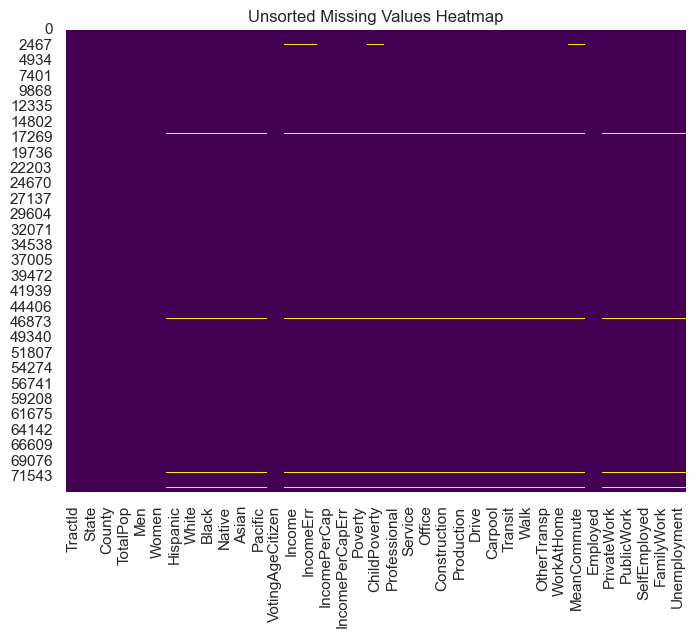

In [79]:
# Exploring Missing Data - ChatGPT 
# Create a boolean DataFrame where True indicates missing values

missing_values = df_original_csv.isnull()

plt.figure(figsize=(8,6))
sns.heatmap(missing_values, cmap='viridis', cbar=False)
plt.title('Unsorted Missing Values Heatmap')
plt.show()

We can also visualize the number of missing values for each column in the dataset. We first calculate the missing values for each column and then filter them to only include the columns with at least one missing value. 

The bar plot below shows the number of missing values in each column, showing only columns with at least one missing value. The bar plot visualization gives us a better idea of how much data is missing in each column before removing them, as per lab instructions, so that we are still informed after removing the instances. 

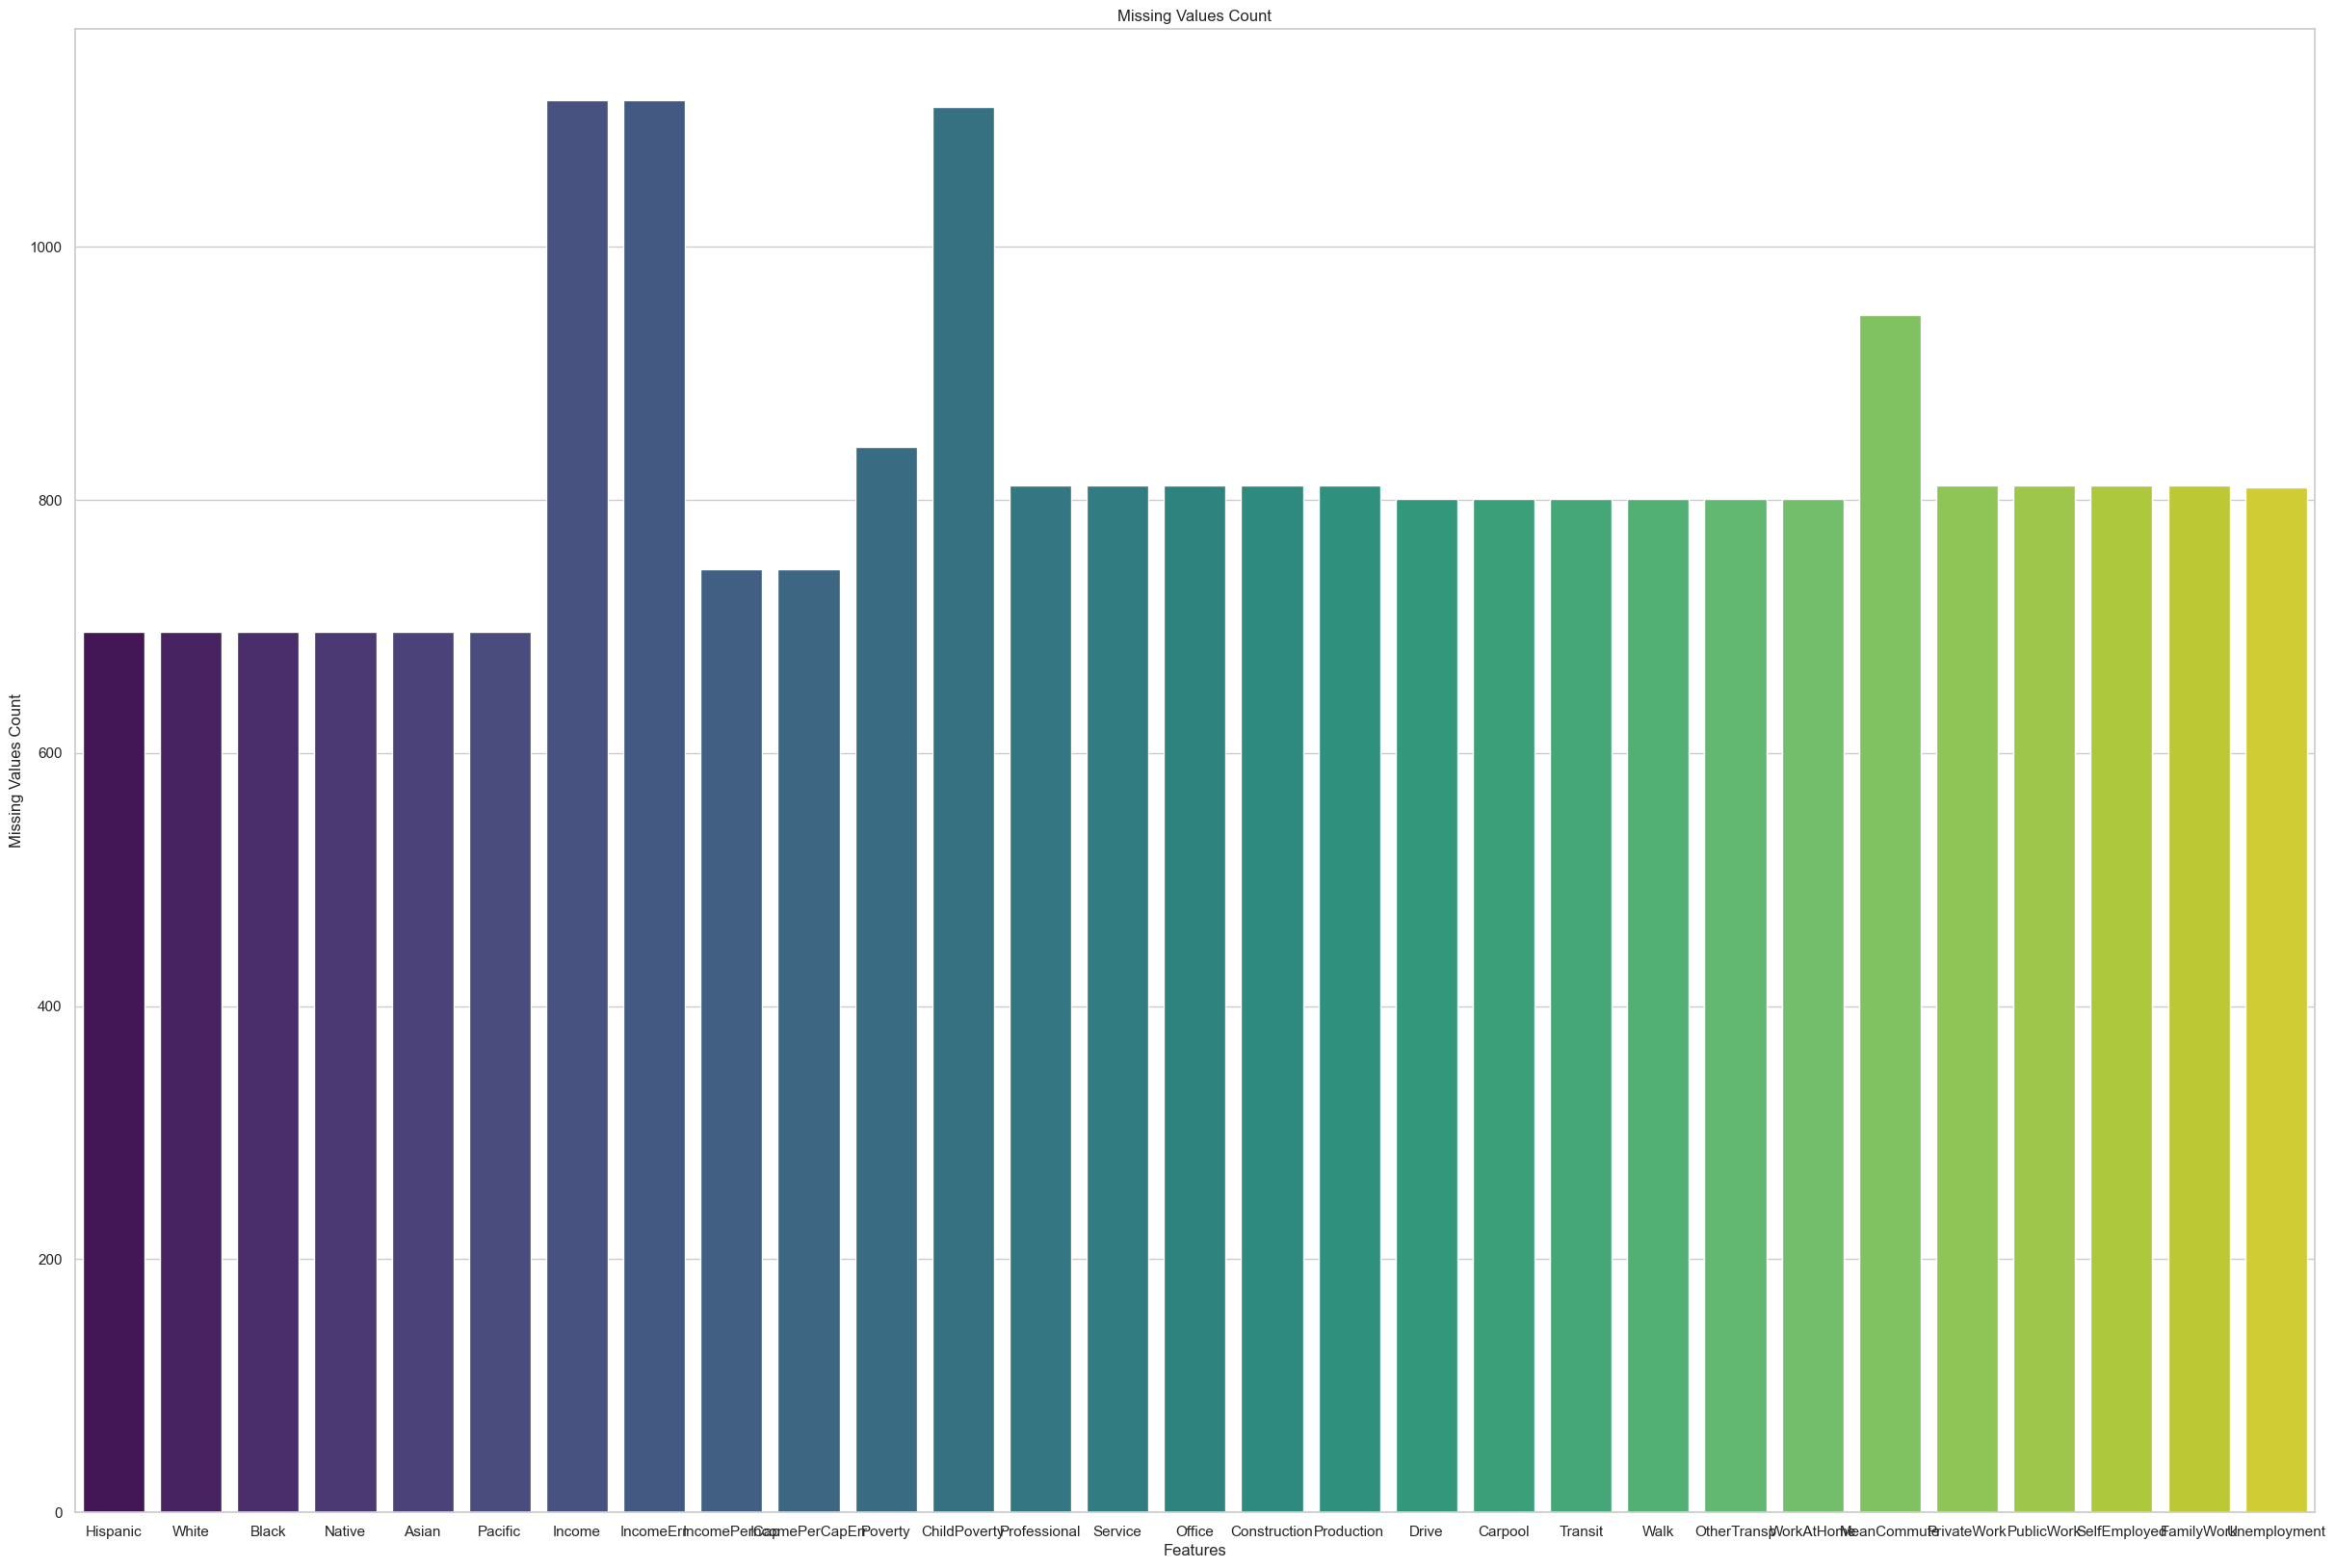

In [80]:
# Bar Plot of missing Values

# Find Missing Values (Sort)
missCount = df_original_csv.isnull().sum()[df_original_csv.isnull().sum() > 0]
sns.set(style = "whitegrid")
plt.figure(figsize=(30, 20))
sns.barplot(x = missCount.index, y = missCount.values, palette = "viridis")
plt.title('Missing Values Count')
plt.xlabel('Features')
plt.ylabel('Missing Values Count')
plt.show()

Missing values across classes are largely even with the exception of peaks when it comes to income data, poverty data, and overall commute times for residents as seen in the barchart. The heatmap above also shows as that proportionally, most data is not missing, and the data that is missing tends to be located in the same rows instead of scattered across the dataset. Because of this phenomenon, we believe it would be best to remove our missing data instead of performing some sort of imputation technique, as per the lab instructions. 

In [81]:
# Remove observations with missing data
df_modified = df_original_csv.dropna(inplace=False)

# Dataset Size - reduced by 1283 instances
row_count, col_count = df_modified.shape
print(f"The dataset contains {row_count} rows and {col_count} columns.")

The dataset contains 72718 rows and 37 columns.


After the removing instances with missing data, we are left with 72718 of the 74001 original instances. We removed roughly 1200 instances with missing data from the dataset.

### **1.3: Remove TractID Column**

We want to make sure that a unique identifier ID variable is not incorporated at all into our analysis, so we remove the TractID variable to ensure it's not factured in whatsoever.

In [82]:
df_modified.drop('TractId', axis=1, inplace=True)

### **1.4: Encode any string data as integers**

Next, we'll encode any strind data as integers because our machine learning algorithms will require numerical input features. String data is not directly interpretable by the algorithms. 

In [83]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Iterate over the columns and encode those with string data
for column in df_modified.columns:
    if df_modified[column].dtype == 'object':
        df_modified[column] = label_encoder.fit_transform(df_modified[column])

df_modified.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72718 entries, 0 to 74000
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   State             72718 non-null  int32  
 1   County            72718 non-null  int32  
 2   TotalPop          72718 non-null  int64  
 3   Men               72718 non-null  int64  
 4   Women             72718 non-null  int64  
 5   Hispanic          72718 non-null  float64
 6   White             72718 non-null  float64
 7   Black             72718 non-null  float64
 8   Native            72718 non-null  float64
 9   Asian             72718 non-null  float64
 10  Pacific           72718 non-null  float64
 11  VotingAgeCitizen  72718 non-null  int64  
 12  Income            72718 non-null  float64
 13  IncomeErr         72718 non-null  float64
 14  IncomePerCap      72718 non-null  float64
 15  IncomePerCapErr   72718 non-null  float64
 16  Poverty           72718 non-null  float64
 17

### **1.5: Remove the "County" variable**

We will also remove the "county" variable because a county's name is not important when predicting a county's child poverty rate based upon other features and collected statistics. Furthermore, a single geographic county may have more than one instance in this dataset. Allowing county names where they may be repeat instances of the same county may introduce unnecessary confusion. 

In [84]:
# Delete "county" variable
df_modified.drop('County', axis=1, inplace=True)

### **1.6: Balance the Dataset**


There are several ways to balance an imbalanced dataset. One option is to use oversampling or undersampling. In this case, we can balance the dataset by choosing quantization thresholds for the "ChildPoverty" variable. 

We can then divide the data into four classes with equal numbers of instances based on the thresholds.

After dividing the dataset into 4 bins, we found that they were divided based on child poverty rates:
- Bin 0: 0.0% to 6.2%
- Bin 1: 6.2% to 16.3%
- Bin 2: 16.3% to 31.6%
- Bin 3: 31.6% to 100.0%

In [85]:
# Visualize the qcut
import seaborn as sns
import matplotlib.pyplot as plt

# Displaying Bin Ranges
bin_ranges = pd.qcut(df_modified['ChildPoverty'], q=4, labels=False, retbins=True)[1]
print("Bin Ranges:")
for i in range(4):
    print(f"Class {i}: {bin_ranges[i]} to {bin_ranges[i+1]}")


Bin Ranges:
Class 0: 0.0 to 6.2
Class 1: 6.2 to 16.3
Class 2: 16.3 to 31.6
Class 3: 31.6 to 100.0


In [ ]:
# Balance the dataset using quantization thresholds
df_modified['ChildPoverty'] = pd.qcut(df_modified['ChildPoverty'], q=4, labels=False)
df_modified['ChildPoverty'].unique()

array([2, 3, 0, 1], dtype=int64)

We also visualized the the bins in a bar plot to show that the bins for each child poverty rate category are of equal count. 

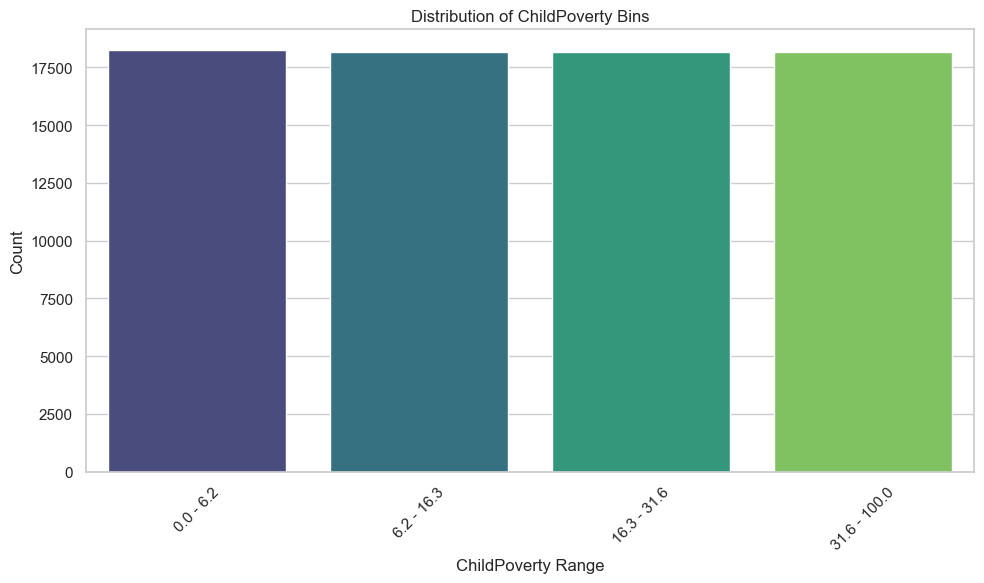

In [87]:
# Assuming df_modified['ChildPoverty'] has already been quantized using qcut
quantized_values = df_modified['ChildPoverty']

# Retrieve the bin edges from the original ChildPoverty column before quantization
_, bin_edges = pd.qcut(df_original_csv['ChildPoverty'], q=4, labels=False, retbins=True)

# Create the bin labels using the bin edges
bin_labels = [f"{bin_edges[i]:.1f} - {bin_edges[i+1]:.1f}" for i in range(4)]

# Get the counts for each bin from the quantized values
bin_counts = quantized_values.value_counts().sort_index()

# Plot the counts for each bin with the custom labels
plt.figure(figsize=(10, 6))
sns.barplot(x=bin_labels, y=bin_counts.values, palette='viridis')
plt.title('Distribution of ChildPoverty Bins')
plt.xlabel('ChildPoverty Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### **1.7: Training and Testing Split**


Finally, we prepare the dataset for machine learning by splitting it into training and testing sets. 80% of the data is used for training and 20% is reserved for testing. We also employed stratification which ensures that the training and testing sets have a similar distribution of classes from the 'ChildPoverty' column, which helps maintain the balance of the classes across the training and testing datasets. 

In [15]:
from sklearn.model_selection import train_test_split

X = df_modified.drop('ChildPoverty', axis=1)  # Exclude the quantized target variable
y = df_modified['ChildPoverty']  # Use the quantized target variable as the target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## **2: Pre-processing and Initial Modeling**

### **2.1: Code for 2-Layer Multi-Layer Perceptron (MLP)**

You will be using a two layer perceptron from class for the next few parts of the rubric. There are several versions of the two layer perceptron covered in class, with example code. When selecting an example two layer network from class be sure that you use: (1) vectorized gradient computation, (2) mini-batching, (3) cross entropy loss, and (4) proper Glorot initialization, at a minimum. There is no need to use momentum or learning rate reduction (assuming you choose a sufficiently small learning rate). It is recommended to use sigmoids throughout the network, but not required.

In [15]:
# Adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta

        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot
    

    # MODIFIED FROM ORIGINAL DR. LARSON IMPLEMENTATION
    def _initialize_weights(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Initialize weights using the Glorot initialization method from Uniform Dist.
        This method provides an initial weight value depending on the number of units in the previous 
        and the next layer, enhancing convergence during training.

        Mathematical representation can be seen below in a Jupyter Notebook markdown
        cell in LaTeX.

        Returns
        -------
        W1, W2, b1, b2
        """
        uniform_bound_W1: float = np.sqrt(6.0 / (self.n_features_ + self.n_hidden))
        W1 = np.random.uniform(-uniform_bound_W1, uniform_bound_W1, (self.n_hidden, self.n_features_))
        b1 = np.zeros((self.n_hidden, 1))

        uniform_bound_W2: float = np.sqrt(6.0 / (self.n_hidden + self.n_output_))
        W2 = np.random.uniform(-uniform_bound_W2, uniform_bound_W2, (self.n_output_, self.n_hidden))
        b2 = np.zeros((self.n_output_, 1))

        return W1, W2, b1, b2

    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    # MODIFIED FROM ORIGINAL DR. LARSON IMPLEMENTATION
    def _cost(self, A3: np.array, Y_enc: np.array, W1: np.array, W2: np.array) -> float:
        """
        Compute the objective function value using cross-entropy

        The objective function is calculated using the cross-entropy loss,
        which is appropriate for binary and multi-class classification tasks
        An L2 regularization term is added to the cross-entropy cost

        Parameters
        ----------
        A3: np.array
            Activations of the output layer, for each instance in the dataset
        Y_enc: np.array
            One-hot encoded true labels corresponding to each instance in the dataset
        W1: np.array
            Weights of the first layer
        W2: np.array
            Weights of the second layer

        Returns
        -------
        float
            Total cost computed as the sum of the cross-entropy cost and the L2 regularization term

        Note
        ----
        Mathematical representation can be seen below in a Jupyter Notebook markdown cell in LaTeX.
        """
        if Y_enc.dtype == bool:
            Y_enc = Y_enc.astype(float)

        if A3.dtype == bool:
            A3 = A3.astype(float)
            
        cost: float = np.mean( (-Y_enc * np.log(A3)) - ((1 - Y_enc) * np.log(1 - A3)) )
        L2_term: float = self._L2_reg(self.l2_C, W1, W2)

        return cost + L2_term
    
    
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ 
        Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- THIS LINE IS FOR CROSS ENTROPY LOSS
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2
    
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

Glorot initialization from a Uniform Distribution that the `_initialize_weights()` function follows is in this format:

$$
w_{ij}^{(L)} \sim U\left[\pm 4 \sqrt{\frac{6}{n^{(L)} + n^{(L+1)}}}\right]
$$

Calculating cost in the `_cost()` function using cross-entropy loss, we use the following formulas for cross-entropy loss: 

$$
-\frac{1}{m}\sum_{i=1}^{m}(y_i \log(a_i) + (1-y_i)\log(1 - a_i)) \\
$$

Continuing this implementation below to include mini-batching below,... 

In [16]:
# just start with the vectorized version and minibatch
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.1, 
                 decrease_iter = 10, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
            
        for i in range(self.epochs):
            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.b1,
                                                       self.b2
                                                      )
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                rho_W1, rho_W2 = eta * gradW1, eta * gradW2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2
                

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
            
        return self

### **2.2: Testing Two-Layer Perceptron with Data in Current State**

In [17]:
# List of parameters to put into our model
vals = {
    'n_hidden': 50, 
    'C': 0.1, 
    'epochs': 100, 
    'eta': 0.05, 
    'alpha': 0.001, 
    'decrease_const': 0.1,
    'decrease_iter': 15,
    'minibatches': 50,
    'shuffle': True,
    'random_state': 1,
}

# Create the 2-layer perceptron model
nn_two_layer = TwoLayerPerceptron(**vals)

# Transform data from pandas into numpy to work in the 2-layer perceptron
X_train_numpy = X_train.values
X_test_numpy = X_test.values
y_train_numpy = y_train.values
y_test_numpy = y_test.values

# Fit the 2-layer perceptron code
%time nn_two_layer.fit(X_train_numpy, y_train_numpy, print_progress=1, XY_test=(X_test_numpy, y_test_numpy))

print("Done")

Epoch: 1/100

Epoch: 100/100

CPU times: user 2min 36s, sys: 13.8 s, total: 2min 50s
Wall time: 19.8 s
Done


In [18]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)

Cross Entropy Loss :
Resubstitution acc: 0.25067899749028777
Validation acc: 0.2506875687568757


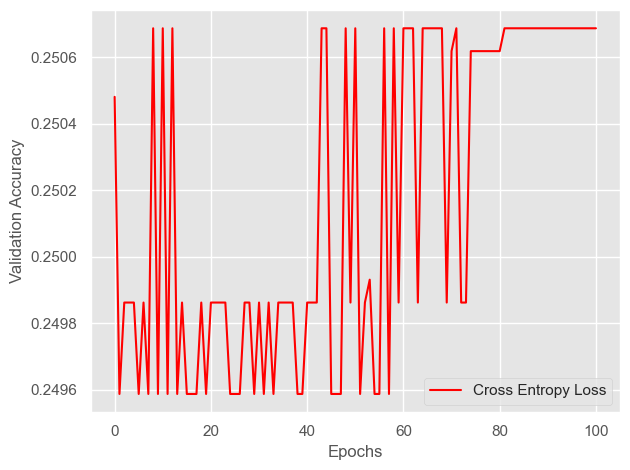

In [19]:
print_result(nn_two_layer,X_train,y_train,X_test,y_test,title="Cross Entropy Loss",color="red")
plt.show()

We can see based on this graph that the training converges after around 85 epochs, and the validation accuracy it converges too is poor at just a little more than 25%.

Preprocessing data is crucial for this 2-layer perceptron (and, quite frankly, for any model) to ensure that the model can effectively discern patterns and make accurate predictions. Given the results from the 2-layer perceptron, the performance closely matches the accuracy one would expect from random guessing in a four-class classification problem (i.e., 25%). The primary reason for this subpar performance is the lack of data preprocessing, specifically the lack of one-hot-encoding and normalization. One-hot encoding is essential for categorical variables, as it transforms them into a format that can be provided to the machine learning algorithm to do a better job in prediction. Without it, the model might misinterpret categorical data as ordinal data, leading to skewed weight updates. Normalization, on the other hand, ensures that all features have a similar scale. This is critical for MLP's, which rely on gradient descent, because features that have larger scales can disproportionately influence the model, causing slower convergence or *making the model get stuck in local minima*, which is likely what happened here with this poor convergence. By neglecting these preprocessing steps, the perceptron struggles to learn meaningful patterns from the data, resulting in a performance that is essentially just random guessing.

### **2.3: Normalizing Continuous Feature Data & Modeling Normalized Data with 2-Layer Perceptron**

Standardizing data using the `StandardScaler` and aiming for a normalization that approximates a normal distribution is advantageous in this case and also in most cases. Here with our 2-layer perceptron, and later with 3-, 4-, and 5-layer perceptrons, the training process assumes that all features have the same scale and behave better when this assumption is met. By ensuring that our features have a mean of 0 and a standard deviation of 1, we help the algorithm converge faster and reach optimal performance. Also, the presence of features with large magnitudes can disproportionately influence model performance. By scaling them down, we ensure that no particular feature exerts undue influence on the model. Although `StandardScaler` doesn't force a perfect Gaussian distribution, it does bring our data closer to what many algorithms expect, which potentially improves efficacy and robustness. Adopting a normalization strategy based on the properties of the normal distribution is an important step, given its foundational role in statistical theory and the central limit theorem, which states that the sum of many independent and identically distributed random variables tends towards a normal distribution.

In [20]:
# ChatGPT code for normalizing columns we wanted to normalize
# Identify columns to standardize. 
cols_to_standardize = [
    'TotalPop', 
    'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific',
    'VotingAgeCitizen', 
    'Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
    'Professional', 'Service', 'Office', 'Construction', 'Production', 'Drive', 'Carpool',
    'Transit', 'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork',
    'PublicWork', 'SelfEmployed', 'FamilyWork', 'Unemployment',
]

# Instantiate the scaler
scaler = StandardScaler()

# Fit on the training data and transform
X_train_standardized = X_train.copy()
X_train_standardized[cols_to_standardize] = scaler.fit_transform(X_train[cols_to_standardize])

# Transform the test data using the same scaler
X_test_standardized = X_test.copy()
X_test_standardized[cols_to_standardize] = scaler.transform(X_test[cols_to_standardize])

Now, lets take a look at the performance of the MLP on this comparatively more preprocessed version of our data. 

In [21]:
# List of parameters to put into our model
vals = {
    'n_hidden': 50, 
    'C': 0.1, 
    'epochs': 100, 
    'eta': 0.05, 
    'alpha': 0.001, 
    'decrease_const': 0.1,
    'decrease_iter': 15,
    'minibatches': 50,
    'shuffle': True,
    'random_state': 1,
}

# Create the 2-layer perceptron model
nn_two_layer_standardazed = TwoLayerPerceptron(**vals)

# Transform data from pandas into numpy to work in the 2-layer perceptron
X_train_standardized_numpy = X_train_standardized.values
X_test_standardized_numpy = X_test_standardized.values

# Fit the 2-layer perceptron code
%time nn_two_layer_standardazed.fit(X_train_standardized_numpy, y_train_numpy, print_progress=1, XY_test=(X_test_standardized_numpy, y_test_numpy))

print("Done")

Epoch: 100/100

CPU times: user 3min 29s, sys: 14 s, total: 3min 43s
Wall time: 26.6 s
Done


Cross Entropy Loss :
Resubstitution acc: 0.5587375803623612
Validation acc: 0.5558993399339934


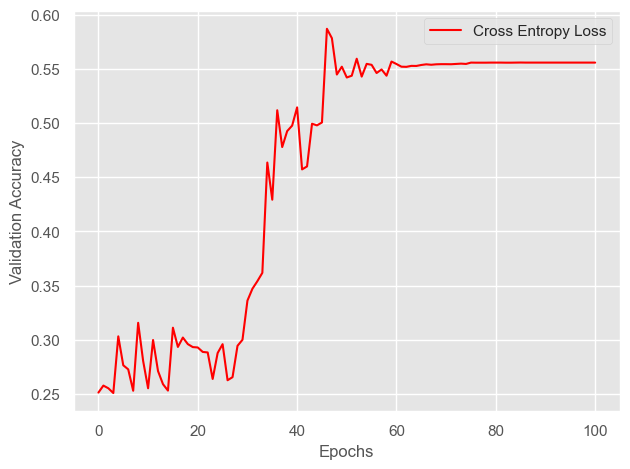

In [22]:
print_result(
    nn_two_layer_standardazed,
    X_train_standardized,
    y_train,
    X_test_standardized,
    y_test,
    title="Cross Entropy Loss",
    color="red",
)
plt.show()

The significant improvement in performance, from the initial results at the performance of random guessing to 55% after normalizing our quantitative independent variables, suggests that our model did not get trapped in the same local minimum as before. The process of normalization likely provided a more evenly scaled data landscape for the optimization algorithm. Thus, with the transformed input features, the algorithm was better able to navigate the loss surface and converge to a more optimal solution, avoiding previously encountered suboptimal minima. However, we have not incorporated the `State` variable into our analysis yet, and we am interested in one-hot-encoding this variable to see how it affects performance here.

Also, note here that the training time did go up in this situation, which might be due to the change in optimization landscape. It could also be random. The training time in this case, however, isn't nearly as much of a deal as it would be in a context where we had a model that was being consistently re-trained in its deployment stage, because here, we are looking at a policy context, which just requires that we have one trained model and used for infering results through our analysis. 

### **2.4: One-Hot-Encoding State Data & Modeling Data with 2-Layer Perceptron**

In [32]:
# Instantiate the encoder
encoder = OneHotEncoder(drop='first')  # drop='first' to avoid dummy variable trap, you can remove if not needed

# Fit on training data and transform it
X_train_state_encoded = encoder.fit_transform(X_train_standardized[['State']])
X_test_state_encoded = encoder.transform(X_test_standardized[['State']])

# Convert to DataFrame for easier handling
X_train_state_encoded_df = (
    pd.DataFrame(
        X_train_state_encoded.toarray(),
        columns=encoder.get_feature_names_out(['State']), 
        index=X_train_standardized.index,
    )
)
X_test_state_encoded_df = (
    pd.DataFrame(
        X_test_state_encoded.toarray(), 
        columns=encoder.get_feature_names_out(['State']), 
        index=X_test_standardized.index,
    )
)

# Drop the original 'State' column and concatenate the one-hot-encoded version
X_train_onehot = pd.concat(
    [X_train_standardized.drop('State', axis=1), X_train_state_encoded_df], 
    axis=1,
)
X_test_onehot = pd.concat(
    [X_test_standardized.drop('State', axis=1), X_test_state_encoded_df], 
    axis=1,
)

In [44]:
# List of parameters to put into our model
vals = {
    'n_hidden': 50, 
    'C': 0.1, 
    'epochs': 100, 
    'eta': 0.05, 
    'alpha': 0.001, 
    'decrease_const': 0.1,
    'decrease_iter': 15,
    'minibatches': 50,
    'shuffle': True,
    'random_state': 10,
}

# Create the 2-layer perceptron model
nn_two_layer_onehot = TwoLayerPerceptron(**vals)

# Transform data from pandas into numpy to work in the 2-layer perceptron
X_train_onehot_numpy = X_train_onehot.values
X_test_onehot_numpy = X_test_onehot.values

# Fit the 2-layer perceptron code
%time nn_two_layer_onehot.fit(X_train_onehot_numpy, y_train_numpy, print_progress=1, XY_test=(X_test_onehot_numpy, y_test_numpy))

print("Done")

Epoch: 1/100

Epoch: 100/100

CPU times: user 3min 34s, sys: 18.3 s, total: 3min 52s
Wall time: 27.2 s
Done


Cross Entropy Loss :
Resubstitution acc: 0.6651768831436724
Validation acc: 0.6538778877887789


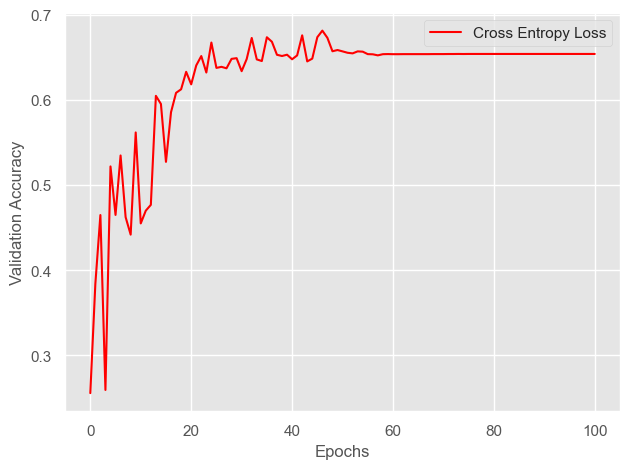

In [45]:
print_result(
    nn_two_layer_onehot,
    X_train_onehot,
    y_train,
    X_test_onehot,
    y_test,
    title="Cross Entropy Loss",
    color="red",
)
plt.show()

The dramatic increase in validation accuracy after one-hot encoding the "State" variable emphasizes the importance of geographic disparities when predicting child poverty class across the United States. By one-hot encoding this variable, each state was given its individual binary column, allowing the model to recognize and factor in the unique socio-economic dynamics inherent to each state.

State-specific policies around education, welfare, healthcare, and employment can create different environments that either alleviate or increase child poverty. Additionally, <a href="https://www.cbpp.org/research/poverty-and-inequality/economic-security-programs-reduce-overall-poverty-racial-and-ethnic">historical factors, local industries, and even climate can result in  variations in living standards and opportunities across states</a>.

Given the context of the dataset, one-hot encoding the "State" variable allows for our model to tap into these regional differences and acknowledge their importance. While the other variables in the dataset, like "Income" or "Unemployment," provide valuable insight into the socio-economic conditions, adding the geographic dimension through one-hot encoding the "State" brings an added layer of granularity. In essence, the model can now distinguish how child poverty manifests differently in, say, a densely populated urban state versus a largely rural one, or in a state with a booming tech industry compared to one reliant on manufacturing or agriculture. By acknowledging these state-specific variations, the model's predictive power for child poverty class is enhanced.

### **2.5: The Statistically Significant Superior Model**

#### **2.5.1: Statistical Test Choice**

To solidify or contradict our belief that the `nn_two_layer_onehot` model performs better than the `nn_two_layer_standardazed` model, we will use the McNemar test to ensure we aren't coming up with that belief solely because of the validation accuracy metric scores. 

The <a href="https://en.wikipedia.org/wiki/McNemar%27s_test">McNemar test</a> is a non-parametric statistical method primarily used to compare the performance of two classification models on the same set of paired data. Essentially, it determines if there's a significant difference in the paired proportion of correct and incorrect predictions between the two models. The test constructs a $2 \times 2$ contingency table based on the disagreement between the predictions, focusing on instances where one model is correct while the other is not. In the context of model performance comparison, if the McNemar test yields a significant result, it solidifies our belief that one model (e.g., `nn_two_layer_onehot`) is indeed performing differently than the other (e.g., `nn_two_layer_standardazed`). Hence, it provides a robust statistical basis for claiming the superiority of one model over another, especially when their performances are close and hard to differentiate purely based on accuracy metrics.

#### **2.5.2: Applying the McNemar Test**

In [68]:
# CHATGPT MCNEMAR TEST CODE
from statsmodels.stats.contingency_tables import mcnemar

# Predictions and true values
y_true = y_test.copy()
y_pred1 = nn_two_layer_standardazed.predict(X_test_standardized_numpy)
y_pred2 = nn_two_layer_onehot.predict(X_test_onehot_numpy)

# Create the contingency table
table = np.zeros((2, 2))

table[0, 0] = np.sum(np.logical_and(y_pred1 == y_true, y_pred2 == y_true))
table[0, 1] = np.sum(np.logical_and(y_pred1 == y_true, y_pred2 != y_true))
table[1, 0] = np.sum(np.logical_and(y_pred1 != y_true, y_pred2 == y_true))
table[1, 1] = np.sum(np.logical_and(y_pred1 != y_true, y_pred2 != y_true))
print(table)

# Apply McNemar's test
result = mcnemar(table, exact=False, correction=True)

print(f"chi-squared statistic={result.statistic:.3f}, p-value={result.pvalue:.3f}")

[[6897. 1188.]
 [2613. 3846.]]
chi squared statistic=533.485, p-value=0.000


The McNemar test results indicate a significant difference in the paired prediction performance between the two models, with a statistic value of 533.485 and an extremely low p-value close to zero. Given that the test focuses on instances where one model's prediction is correct and the other's is not, the large statistic value suggests a considerable and statistically significant disparity in their predictive disagreements. Specifically, since the p-value is well below any conventional significance level (e.g., 0.05), we can confidently reject the null hypothesis that both models perform similarly on the dataset. Given the results and the nature of the test, we can conclude that the nn_two_layer_onehot model demonstrates a statistically significant superior performance in predicting child poverty class compared to the nn_two_layer_standardazed model on the paired test data.

Because of this conclusion, we will use `X_train_onehot_numpy` as our training data for the 3, 4, and 5 layer perceptrons going forward.

In [51]:
X_train = X_train_onehot_numpy.copy()
X_test = X_test_onehot_numpy.copy()
y_train = y_train_numpy.copy()
y_test = y_test_numpy.copy()

## **3: Multi-Layer Perceptron (MLP) Implementation**

### **3.1: MLP Implementation**

In [52]:
# =================
# Import Statements
# =================

# Standard Stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

# Sklearn Imports
from scipy.special import expit
from sklearn.metrics import accuracy_score

# ==========================
# MultiLayerPerceptron Class
# ==========================

class MultiLayerPerceptron:

    def __init__(self, layers, C = 0.0, epochs = 500, eta = 0.001, random_state = None, 
                 alpha = 0.1, decrease_const = 0.0, shuffle = True, minibatches = 1):
        """
        Initialize The Multi Layer Perceptron (MLP) Classifier.

        Parameters, Attributes, Descriptions:
        - layers:           List Of Integers,   Representing No. Units In Each MLP Layer.
        - C:                Float,              Regularization Parameter.
        - epochs:           Int,                No. Iterations Over Entire Dataset.
        - eta:              Float,              Learning Rate.
        - random_state:     Int,                Seed For Random Weight Initialization, Shuffling.
        - alpha:            Float,              Momentum Coefficient To Improve Convergence.
        - decrease_const:   Float,              Reduces Learning Rate Every Epoch.
        - shuffle:          Bool,               Whether To Shuffle Dataset Every Epoch.
        - minibatches:      Int,                No. Minibatches To Split Dataset Into.
        """

        # Seed For Reproducability
        np.random.seed(random_state)

        # Store Architecture, Regularization, Optimization Parameters
        self.layers = layers
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        
    # ===============
    # Utility Methods
    # ===============

    @staticmethod
    def _encode_labels(y):
        """ Encode Labels Into One-Hot Representation """
        onehot = pd.get_dummies(y).values.T
        return onehot
    
    @staticmethod
    def _sigmoid(z):
        """ Use Scipy Expit To Avoid Overflow (Sigmoid Activation Function) """
        return expit(z)
    
    def _L2_reg(self):
        """ Compute L2 Regularization Cost """
        return self.l2_C * np.sum([np.mean(w ** 2) for w in self.W])
    
    def _cost(self, A, Y_enc):
        """ Compute Objective Function Value Using Cross-Entropy Loss """
        m = Y_enc.shape[1]

        # Compute Cross-Entropy Loss (Negative Log Likelihood)
        cost = -1 / m * np.sum(Y_enc * np.log(A[-1]))
        L2_term = self._L2_reg()
        return cost + L2_term

    # ====================
    # Feed Forward Methods
    # ====================

    # Initialize Weight, Bias Matrices
    def _initialize_weights(self):

        # Initialize Weights, Biases
        W = []
        b = []
        layer_input = self.n_features_

        # Initialize Weights For Hidden Layers
        for layer in self.layers:

            # Glorot Initialization
            init_bound = np.sqrt(6. / (layer_input + layer))
            W.append(np.random.uniform(-init_bound, init_bound, (layer, layer_input)))
            b.append(np.zeros((layer, 1)))
            layer_input = layer
        
        # Initialize Weights For Output Layer
        init_bound = np.sqrt(6. / (layer_input + self.n_output_))
        W.append(np.random.uniform(-init_bound, init_bound, (self.n_output_, layer_input)))
        b.append(np.zeros((self.n_output_, 1)))

        # Return Weights, Biases
        return W, b
    
    # Compute Forward Pass Through Network
    def _feedforward(self, X):

        # Initialize Activations
        A = [X.T]
        Z = []

        # Compute Activations For All Layers
        for w, b in zip(self.W, self.b):
            z = w @ A[-1] + b
            Z.append(z)
            a = self._sigmoid(z)
            A.append(a)

        # Compute Softmax Activations For Output Layer
        A[-1] = np.exp(Z[-1]) / np.sum(np.exp(Z[-1]), axis = 0)
        return A, Z
    
    # Compute Gradient Using Backpropagation
    def _get_gradient(self, A, Z, Y_enc):

        # Start From Output Layer
        V = [A[-1] - Y_enc]

        # Compute Pre-Activation Gradient For All Layers (Reversed => Backpropagation)
        for i in reversed(range(1, len(self.layers) + 1)):
            v = A[i] * (1 - A[i]) * (self.W[i].T @ V[-1])
            V.append(v)
        V = V[::-1]

        # Compute Gradients For All Weight Matrices, Bias Vectors
        gradW = []
        gradb = []
        for i in range(len(V)):
            gradW.append(V[i] @ A[i].T)
            gradb.append(np.sum(V[i], axis = 1, keepdims = True))
        return gradW, gradb
    
    # ==============
    # Public Methods
    # ==============

    # Train The Neural Network
    def fit(self, X, y, print_progress = 0):
        """ Learn Weights From Training Data """
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W, self.b = self._initialize_weights()
        self.cost_ = []

        # Store Gradient Magnitudes
        self.grad_magnitudes_ = []
        
        # Run Loop For Each Epoch
        progress_interval = max(1, self.epochs // print_progress)
        for i in range(self.epochs):

            # Print Current Progress (Padding For Fixed Output)
            if print_progress > 0 and (i + 1) % progress_interval == 0:
                msg = '\rEpoch: {}/{}'.format(i + 1, self.epochs)
                sys.stderr.write(msg + ' ' * (20 - len(msg)))
                sys.stderr.flush()
            
            # Shuffle Dataset For Method
            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            # Split Data Into Minibatches For Minibatch Gradient Descent
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)

            # Store Costs, Gradient Magnitudes For This Epoch
            mini_cost = []
            epoch_grads = []

            # Perform Method
            for idx in mini:
                A, Z = self._feedforward(X_data[idx])
                cost = self._cost(A, Y_enc[:, idx])
                mini_cost.append(cost)

                # Vectorized Gradient Computation
                gradW, gradb = self._get_gradient(A = A, Z = Z, Y_enc = Y_enc[:, idx])

                # Compute Gradient Magnitudes Using L2 Norm
                grad_mags = [np.linalg.norm(gw) for gw in gradW]
                epoch_grads.append(grad_mags)
                for w, grad_w, b, grad_b in zip(self.W, gradW, self.b, gradb):
                    w -= self.eta * grad_w
                    b -= self.eta * grad_b
            self.cost_.append(mini_cost)

            # Store Average Gradient Magnitudes For Each Layer, For Each Epoch (Over Minibatches)
            self.grad_magnitudes_.append(np.mean(epoch_grads, axis = 0))
            
        return self

    def predict(self, X):
        """ Predict Class Labels """
        A, _ = self._feedforward(X)
        y_pred = np.argmax(A[-1], axis = 0)
        return y_pred

### **3.2: Testing the MLP**

In [64]:
# Initialize Hyperparameters (Can Be Changed):
vals = { 
    'C':                0.0, 
    'epochs':           500, 
    'eta':              0.001,
    'random_state':     1,
    'alpha':            0.01,
    'shuffle':          True,
    'minibatches':      len(X_train) / 32
}

# Define Layer Configurations For Testing (Can Be Changed):
layer_configs = [
    [50],           # Three Layers: Input + 1 Hidden + Output
    [50, 50],       # Four Layers: Input + 2 Hidden + Output
    [50, 50, 50],   # Five Layers: Input + 3  Hidden + Output
    [50, 100, 50],  # Five Layer Bottleneck Structure
]

# Initialize Empty Dictionaries => Store Results, Gradient Magnitudes, Costs
results = {}
gradient_magnitudes = {}
avg_costs = {}

# Loop Through Each Layer Configuration, Test MLP Classifier
for config in layer_configs:

    # Initialize MLP With Current Configuration, Values
    nn = MultiLayerPerceptron(layers = config, **vals)

    # Fit, Predict, Compute Accuracy
    nn.fit(X_train, y_train, print_progress = 10)
    yhat = nn.predict(X_test)
    accuracy = accuracy_score(y_test, yhat)
    results[tuple(config)] = accuracy
    gradient_magnitudes[tuple(config)] = nn.grad_magnitudes_
    avg_costs[tuple(config)] = [np.mean(x) for x in nn.cost_]

# Print Results:
print("\nLayer, Accuracy Results:")
for config, accuracy in results.items():
    print(config, accuracy)

Epoch: 500/500     


Layer, Accuracy Results:
(50,) 0.7206408140814081
(50, 50) 0.7220159515951595
(50, 50, 50) 0.7216034103410341
(50, 100, 50) 0.7230473047304731


The validation accuracy metrics from the custom multilayer perceptron models, differentiated by their hidden layer neuron counts, perform similar to each other. The configuration with a reverse bottleneck architecture, (50, 100, 50), stands out as a little bit better than the rest. One plausible explanation for the 4-layer MLP outperforming the 5-layer MLP where all the neuron counts are 50 for each hidden layer could be attributed to the vanishing gradients problem kicking in but not yet showcasing a significantly dropoff in accuracy. The additional complexity introduced by the 5th layer might be capturing noise rather than underlying patterns as well, leading to slightly compromised performance on validation or test data.

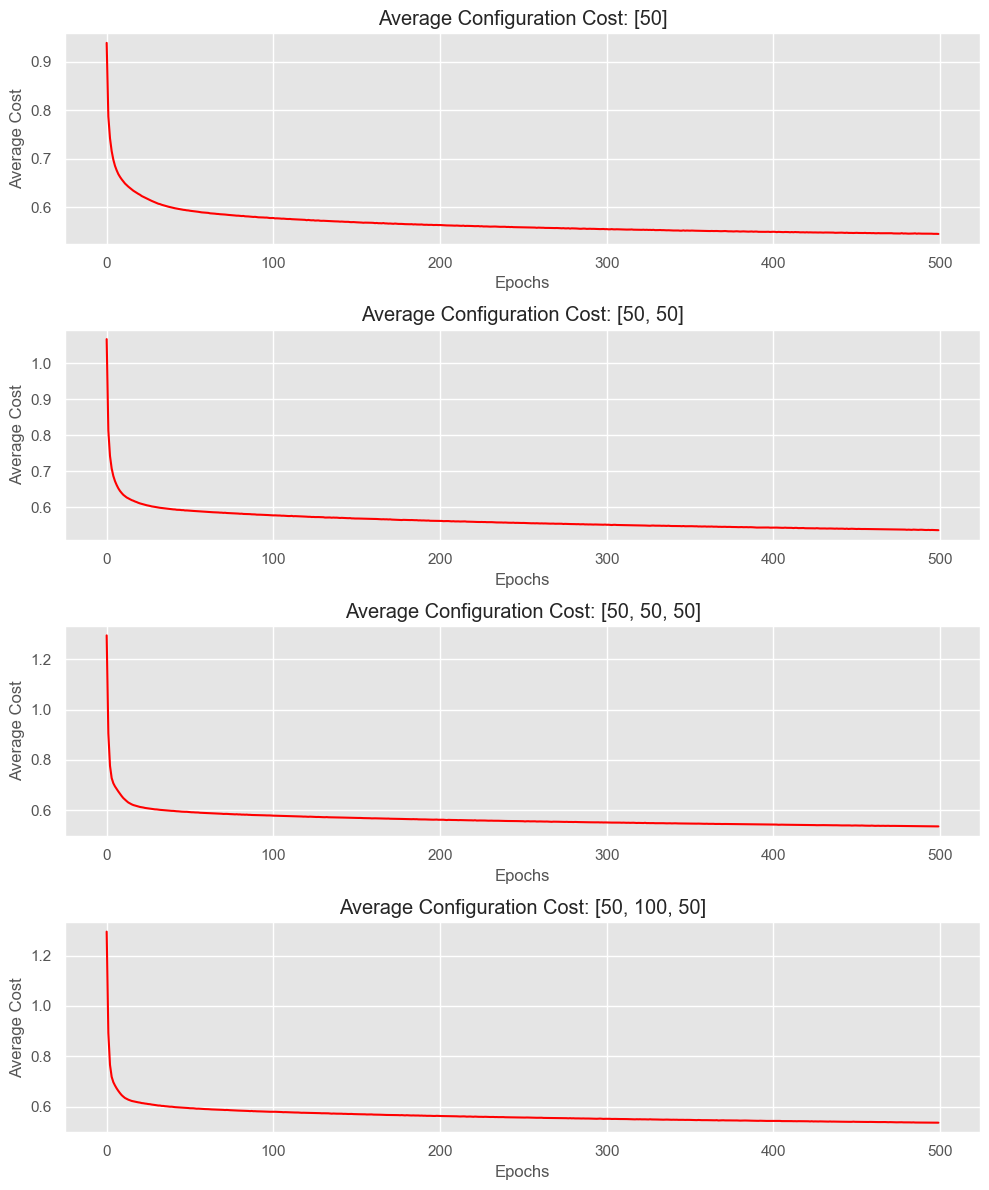

In [66]:
# Plotting Average Costs Against Epochs For Each Configuration
fig, axes = plt.subplots(nrows = len(layer_configs), figsize = (10, 12))

# Plot Loss Function For Each Configuration
for ax, config in zip(axes, layer_configs):
    cost_avgs = avg_costs[tuple(config)]
    ax.plot(range(len(cost_avgs)), cost_avgs, color = 'red')
    ax.set_title(f'Average Configuration Cost: {config}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Average Cost')
    ax.grid(True)

# Show Plot
plt.tight_layout()
plt.show()

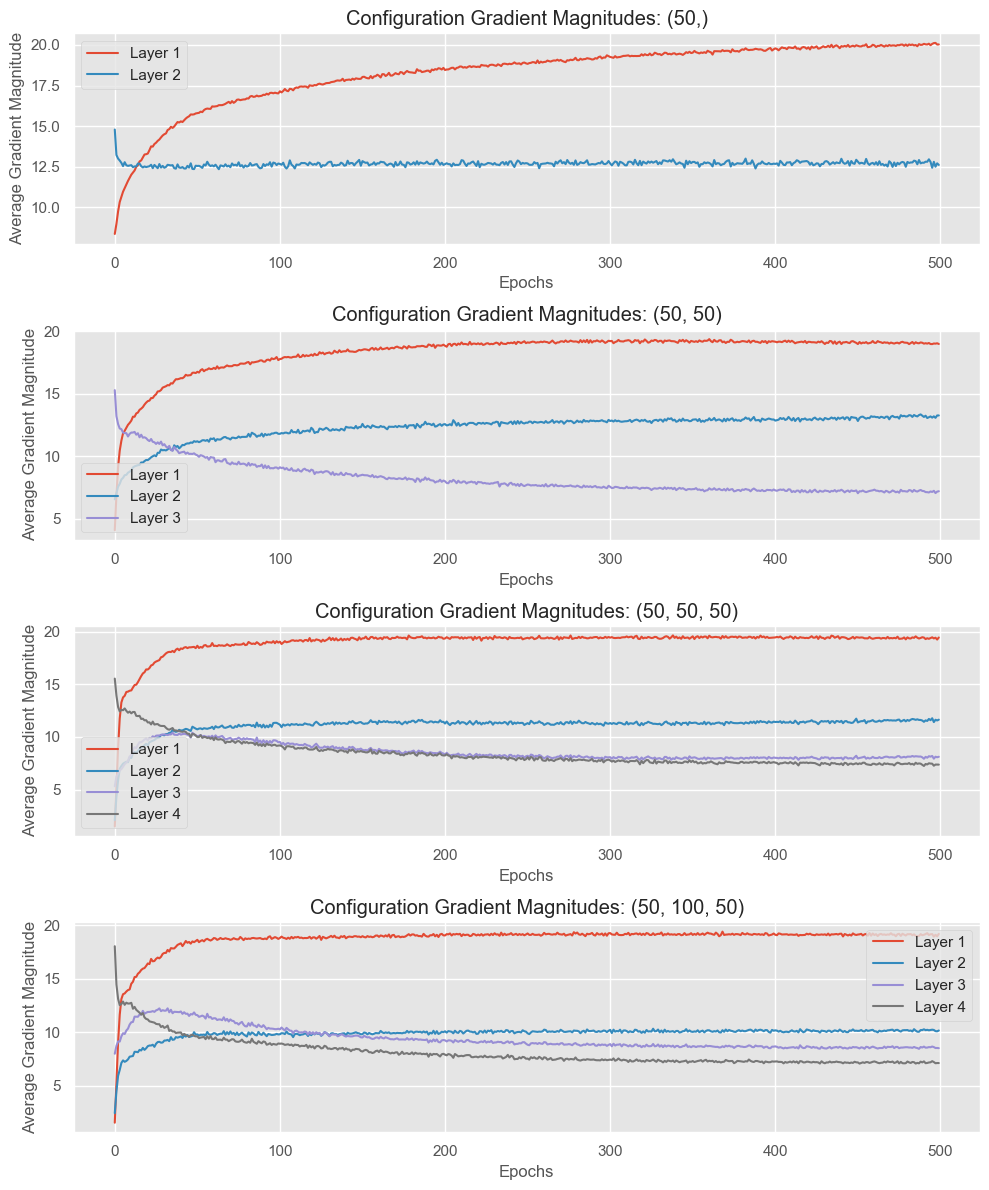

In [67]:
# Plotting Gradient Magnitudes Against Epochs For Each Configuration
fig, axes = plt.subplots(nrows = len(layer_configs), figsize = (10, 12))

# Plot Gradient Magnitudes For Each Configuration
for ax, (config, grads) in zip(axes, gradient_magnitudes.items()):
    grads = np.array(grads)
    for i in range(grads.shape[1]):
        ax.plot(grads[:, i], label = f'Layer {i+1}')
    ax.set_title(f'Configuration Gradient Magnitudes: {config}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Average Gradient Magnitude')
    ax.legend()
    ax.grid(True)

# Show Plot
plt.tight_layout()
plt.show()

### **3.3: Adaptive MultiLayerPerceptron (MLP) Implementation**

In [55]:
# ===================================
# Adaptive MultiLayerPerceptron Class
# ===================================

class MultiLayerPerceptronAdaptive(MultiLayerPerceptron):
    def __init__(self, layers, adaptive = None, C = 0.0, epochs = 500, eta = 0.001, 
                 beta1 = 0.9, beta2 = 0.999, epsilon = 1e-7, random_state = None, 
                 alpha = 0.1, decrease_const = 0.0, shuffle = True, minibatches = 1):
        """
        Initialize the Adaptive Multi Layer Perceptron (MLP) Classifier with advanced optimization techniques.

        Parameters, Attributes, Descriptions:
        - adaptive:     String,     Optimization Technique To Be Used (e.g., "rmsprop", "adam", "adamw").
        - beta1:        Float,      Exponential Decay Rate For First Moment In Adam Optimization.
        - beta2:        Float,      Exponential Decay Rate For Second Moment In Adam Optimization.
        - epsilon:      Float,      Small Value To Prevent Division By Zero In Adam Optimization.
        """
        super().__init__(layers, C, epochs, eta, random_state, alpha, decrease_const, shuffle, minibatches)

        # Additional Attributes For Adaptive Optimization
        self.adaptive = adaptive
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

    def _initialize_weights(self):
        """ Initialize Weights With Additional Parameters For Adaptive Optimization """
        W, b = super()._initialize_weights()

        # Initialize Additional Parameters For Adaptive Optimization
        if self.adaptive:

            # First Moment For Adam Optimization
            self.M_W = [np.zeros(w.shape) for w in W]
            self.M_b = [np.zeros(bi.shape) for bi in b]

            # Second Moment For Adam, RMSProp Optimization
            self.S_W = [np.zeros(w.shape) for w in W]
            self.S_b = [np.zeros(bi.shape) for bi in b]

        return W, b
    
    def _update_weights(self, gradW, gradb, t):
        """ Update Weights Using Chosen Optimization Technique """

        # Loop Through Each Layer's Weights, Gradients
        for i, (w, grad_w, b, grad_b) in enumerate(zip(self.W, gradW, self.b, gradb)):
            
            # RMSProp Optimization
            if self.adaptive == "rmsprop":

                # Update Moving Average Of Squared Gradients - For Weight, Bias
                self.S_W[i] = self.beta2 * self.S_W[i] + (1 - self.beta2) * grad_w**2
                w -= self.eta * grad_w / (np.sqrt(self.S_W[i]) + self.epsilon)
                self.S_b[i] = self.beta2 * self.S_b[i] + (1 - self.beta2) * grad_b**2
                b -= self.eta * grad_b / (np.sqrt(self.S_b[i]) + self.epsilon)
            
            # Adam / AdamW Optimization
            elif self.adaptive == "adam" or self.adaptive == "adamw":

                # Update First, Second Moment (Moving Average Of Gradients)
                self.M_W[i] = self.beta1 * self.M_W[i] + (1 - self.beta1) * grad_w
                self.S_W[i] = self.beta2 * self.S_W[i] + (1 - self.beta2) * grad_w**2

                # Bias Correction For Moments
                m_w_corrected = self.M_W[i] / (1 - self.beta1**t)
                s_w_corrected = self.S_W[i] / (1 - self.beta2**t)

                # Apply Adam Update Rule 
                w -= self.eta * m_w_corrected / (np.sqrt(s_w_corrected) + self.epsilon)
                
                # Same For Biases
                self.M_b[i] = self.beta1 * self.M_b[i] + (1 - self.beta1) * grad_b
                self.S_b[i] = self.beta2 * self.S_b[i] + (1 - self.beta2) * grad_b**2
                m_b_corrected = self.M_b[i] / (1 - self.beta1**t)
                s_b_corrected = self.S_b[i] / (1 - self.beta2**t)
                b -= self.eta * m_b_corrected / (np.sqrt(s_b_corrected) + self.epsilon)
                
                # AdamW Added Weight Decay (For Regularization)
                if self.adaptive == "adamw":
                    w -= self.eta * self.l2_C * w
                    b -= self.eta * self.l2_C * b
            
            # Basic Weight Update Without Optimization
            else:
                w -= self.eta * grad_w
                b -= self.eta * grad_b

    def fit(self, X, y, print_progress = 0):
        """ Learn Weights From Training Data With Chosen Optimization Technique"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W, self.b = self._initialize_weights()
        self.cost_ = []
        
        # Store Gradient Magnitudes
        self.grad_magnitudes_ = []
        
        # Run Loop For Each Epoch
        progress_interval = max(1, self.epochs // print_progress)
        for i in range(self.epochs):
                
            # Print Current Progress (Padding For Fixed Output)
            if print_progress > 0 and (i + 1) % progress_interval == 0:
                msg = '\rEpoch: {}/{}'.format(i + 1, self.epochs)
                sys.stderr.write(msg + ' ' * (20 - len(msg)))
                sys.stderr.flush()

            # Shuffle Dataset For Method
            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]
            
            # Split Data Into Minibatches For Minibatch Gradient Descent
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)

            # Store Costs, Gradient Magnitudes For This Epoch
            mini_cost = []
            epoch_grads = []
            
            # Perform Method
            for idx in mini:
                A, Z = self._feedforward(X_data[idx])
                cost = self._cost(A, Y_enc[:, idx])
                mini_cost.append(cost)

                # Vectorized Gradient Computation
                gradW, gradb = self._get_gradient(A=A, Z=Z, Y_enc=Y_enc[:, idx])

                # Compute Gradient Magnitudes Using L2 Norm
                grad_mags = [np.linalg.norm(gw) for gw in gradW]
                epoch_grads.append(grad_mags)
                
                # Update Weights Using Chosen Optimization Technique (Changed Section)
                self._update_weights(gradW, gradb, i+1)
            self.cost_.append(mini_cost)

            # Store Average Gradient Magnitudes For Each Layer, For Each Epoch (Over Minibatches)
            self.grad_magnitudes_.append(np.mean(epoch_grads, axis = 0))
        
        return self

### **3.4: Adaptive MultiLayerPerceptron (MLP) Testing**

In [69]:
# List Adaptive Techniques (For Testing)
adaptive_techniques = ["nothing lol", "rmsprop", "adam", "adamw"]

# Initialize Empty Dictionaries => Store Results, Gradient Magnitudes, Costs
results_adaptive = {}
gradient_magnitudes_adaptive = {}
avg_costs_adaptive = {}

# 50 neuron models list
neural_network_list = []

# Loop Through Each Adaptive Technique, Test MLP Classifier
for technique in adaptive_techniques:

    # Initialize MLP With Current Configuration, Values
    nn = MultiLayerPerceptronAdaptive(layers = [50, 50, 50], adaptive = technique, **vals)

    # Fit, Predict, Compute Accuracy
    nn.fit(X_train, y_train, print_progress = 10)
    yhat = nn.predict(X_test)
    accuracy = accuracy_score(y_test, yhat)
    results_adaptive[technique] = accuracy
    gradient_magnitudes_adaptive[technique] = nn.grad_magnitudes_
    avg_costs_adaptive[technique] = [np.mean(x) for x in nn.cost_]

    # Append the neural network list to compare with McNemar test later
    neural_network_list.append(nn)

# Print Results:
print("\nTechnique, Accuracy Results:")
for technique, accuracy in results_adaptive.items():
    print(technique, accuracy)

Epoch: 500/500     


Technique, Accuracy Results:
nothing lol 0.7216034103410341
rmsprop 0.6722359735973598
adam 0.7060643564356436
adamw 0.7060643564356436


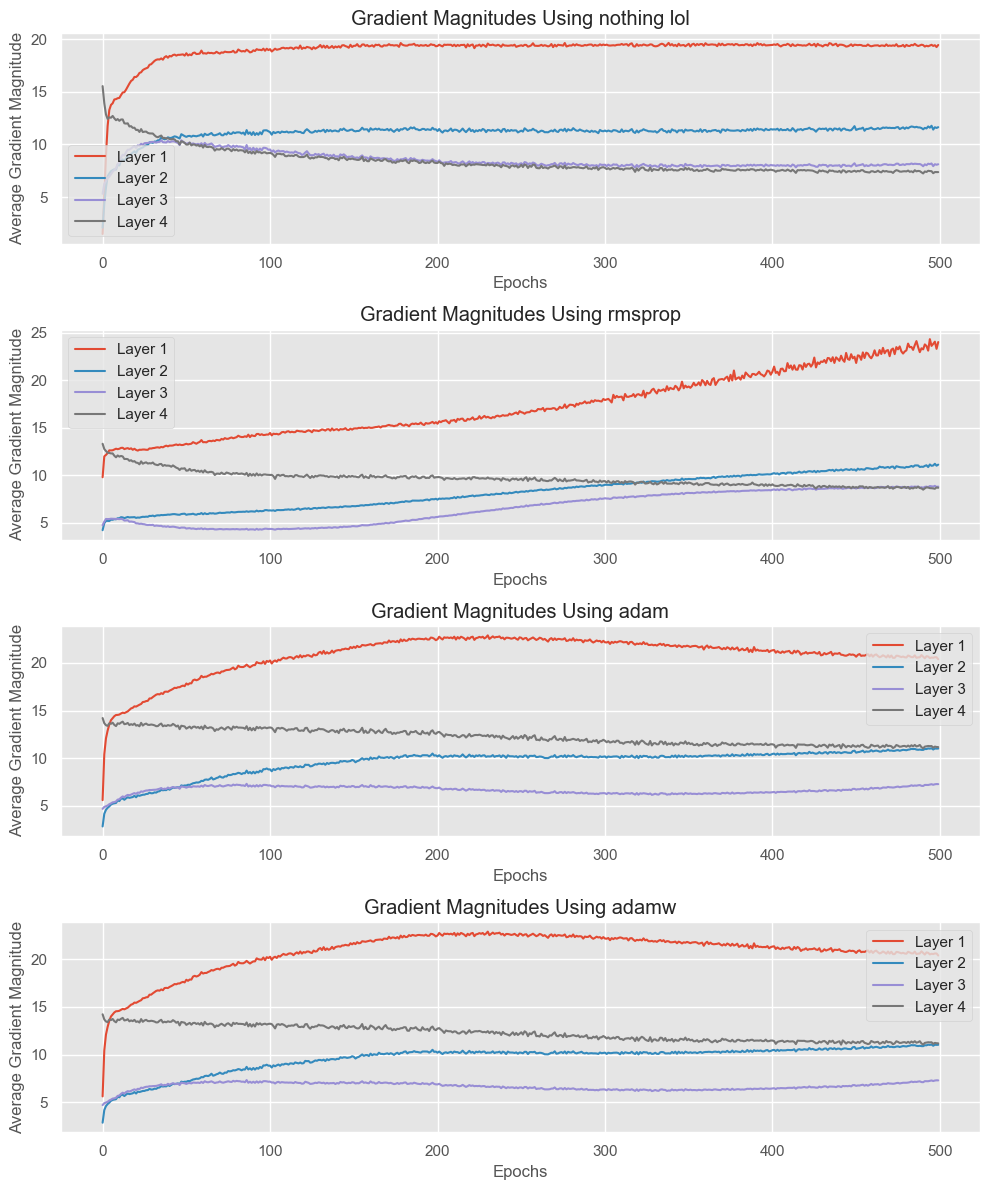

In [70]:
# Plotting Gradient Magnitudes For Adaptive Techniques
fig, axes = plt.subplots(nrows = len(adaptive_techniques), figsize = (10, 12))

# Plot Gradient Magnitudes For Each Technique
for ax, (technique, grads) in zip(axes, gradient_magnitudes_adaptive.items()):
    grads = np.array(grads)
    for i in range(grads.shape[1]):
        ax.plot(grads[:, i], label = f'Layer {i + 1}')
    ax.set_title(f'Gradient Magnitudes Using {technique}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Average Gradient Magnitude')
    ax.legend()
    ax.grid(True)

# Show Plot
plt.tight_layout()
plt.show()


Adam: https://arxiv.org/pdf/1412.6980.pdf

AdamW: https://arxiv.org/pdf/1711.05101.pdf

Furthermore, each dimension of the gradient is rescaled similar to RMSprop. One key difference between Adam and RMSprop (or AdaGrad) is the fact that the moment estimates m and v are corrected for their bias towards zero. Adam is well-known for achieving good performance with little hyper-parameter tuning. SGD+Momentum is rotation invariant whereas Adam/RMSProp/Adadelta are not. They do the best when principal directions of variations in gradient noise are axis aligned. So perhaps they are getting unlucky with the rotation

### **3.5: Comparing 5-Layer Adam Adaptive Learning with Model Without It**

In [71]:
# Initialize 5-layer MLP with and without Adam
nn_5_without_adam = neural_network_list[0]
nn_5_with_adam = neural_network_list[2]

# Predictions and true values
y_true = y_test.copy()
y_pred1 = nn_5_without_adam.predict(X_test)
y_pred2 = nn_5_with_adam.predict(X_test)

# Create the contingency table
table = np.zeros((2, 2))

table[0, 0] = np.sum(np.logical_and(y_pred1 == y_true, y_pred2 == y_true))
table[0, 1] = np.sum(np.logical_and(y_pred1 == y_true, y_pred2 != y_true))
table[1, 0] = np.sum(np.logical_and(y_pred1 != y_true, y_pred2 == y_true))
table[1, 1] = np.sum(np.logical_and(y_pred1 != y_true, y_pred2 != y_true))
print(table)

# Apply McNemar's test
result = mcnemar(table, exact=False, correction=True)

print(f"chi-squared statistic={result.statistic:.3f}, p-value={result.pvalue:.3f}")

[[9424. 1071.]
 [ 845. 3204.]]
chi-squared statistic=26.422, p-value=0.000


The McNemar test results indicate a significant difference in the paired prediction performance between the two models, with a $\chi^2$ statistic value of 26.422 and an extremely low p-value close to zero. Given that the test focuses on instances where one model's prediction is correct and the other's is not, the large statistic value suggests a considerable and statistically significant disparity in their predictive disagreements. Specifically, since the p-value is well below any conventional significance level (e.g., 0.05), we can confidently reject the null hypothesis that both models perform similarly on the dataset. Given the results and the nature of the test, we can conclude that the 5-Layer Perceptron without Adam demonstrates a noticibly and statistically significant superior performance in predicting child poverty class compared to the the 5-Layer Perceptron model with Adam on the paired test data. The 5-Layer Perceptron without Adam has an accuracy of ~72.16%, whereas the perceptron with Adam yields an accuracy of ~70.61%, allowing us to believe that the model without Adam has a superior performance.

In [72]:
# Initialize 5-layer MLP with and without RMSProp
nn_5_without_rmsprop = neural_network_list[0]
nn_5_with_rmsprop = neural_network_list[1]

# Predictions and true values
y_true = y_test.copy()
y_pred1 = nn_5_without_rmsprop.predict(X_test)
y_pred2 = nn_5_with_rmsprop.predict(X_test)

# Create the contingency table
table = np.zeros((2, 2))

table[0, 0] = np.sum(np.logical_and(y_pred1 == y_true, y_pred2 == y_true))
table[0, 1] = np.sum(np.logical_and(y_pred1 == y_true, y_pred2 != y_true))
table[1, 0] = np.sum(np.logical_and(y_pred1 != y_true, y_pred2 == y_true))
table[1, 1] = np.sum(np.logical_and(y_pred1 != y_true, y_pred2 != y_true))
print(table)

# Apply McNemar's test
result = mcnemar(table, exact=False, correction=True)

print(f"chi-squared statistic={result.statistic:.3f}, p-value={result.pvalue:.3f}")

[[8714. 1781.]
 [1063. 2986.]]
chi-squared statistic=180.763, p-value=0.000


# **SKLearn MLP Testing**

In [61]:
# =================
# Import Statements
# =================

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Values Hand Tuned, Sigmoid W/ SGD, Batching, Nesterov's Momentum, L2, Adaptive Learning Rate

# Hand Tuned Parameters
clf = MLPClassifier(hidden_layer_sizes =  (50,), 
                    activation =          'logistic', # Compare To Sigmoid
                    solver =              'sgd', 
                    alpha =               1e-4,       # L2 penalty
                    batch_size =          128,        # Min 128
                    learning_rate =       'adaptive', # Decrease Rate If Loss Increases
                    learning_rate_init =  0.1,        # Only For SGD
                    power_t =             0.5,        # Only SGD With Inverse Scaling
                    max_iter =            100, 
                    shuffle =             True, 
                    random_state =        1, 
                    tol =                 1e-9,       # For Stopping
                    verbose =             False, 
                    warm_start =          False, 
                    momentum =            0.9,        # Only SGD
                    nesterovs_momentum =  True,       # Only SGD
                    early_stopping =      False, 
                    validation_fraction = 0.1,        # Only If Early Stopping
                    beta_1 =              0.9,        # Adam Decay Rate Of Moment
                    beta_2 =              0.999,      # Adam Decay Rate Of Moment
                    epsilon =             1e-08)      # Adam Numerical Stabilizer

# Run Prediction
%time clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
print('Validation Accuracy:', accuracy_score(yhat, y_test))

CPU times: user 4min 36s, sys: 3.07 s, total: 4min 40s
Wall time: 31.9 s
Validation Accuracy: 0.7208470847084708


In [63]:
# Hand Tuned Parameters (Adam Optimization)
clf = MLPClassifier(hidden_layer_sizes =  (50,), 
                    activation =          'relu',     # Type Of Non-Linearity, Every Layer Except Output Layer
                    solver =              'adam', 
                    alpha =               1e-4,       # L2 penalty
                    batch_size =          128,        # Min 128
                    learning_rate =       'adaptive', # Decrease Rate If Loss Increases
                    learning_rate_init =  0.1,        # Only For SGD
                    power_t =             1,          # Only SGD With Inverse Scaling
                    max_iter =            100, 
                    shuffle =             True, 
                    random_state =        1, 
                    tol =                 0,          # For Stopping
                    verbose =             False, 
                    warm_start =          False, 
                    momentum =            0.9,        # Only SGD
                    nesterovs_momentum =  False,      # Only SGD
                    early_stopping =      False, 
                    validation_fraction = 0.0,        # Only If Early Stopping
                    beta_1 =              0.9,        # Adam Decay Rate Of Moment
                    beta_2 =              0.999,      # Adam Decay Rate Of Moment
                    epsilon =             1e-08)      # Adam Numerical Stabilizer

# Run Prediction
%time clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
print('Validation Accuracy:', accuracy_score(yhat, y_test))

CPU times: user 46.9 s, sys: 518 ms, total: 47.5 s
Wall time: 5.28 s
Validation Accuracy: 0.6937568756875687


We found that scikit-learn's MLP and our MLP perform similarly with validation accuracies around 70%. 